# How to use the simple GAN (Generative Adversarial Network) in PyTorch

In [ ]:
# Core Libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Data Handling & Preprocessing
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Visualization & Debugging
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation
The dataset I'm using is UNSW-NB15, the data already split so I don't need to split it manually. The dataset is divided into:
- Training-set with CSV format.
- Testing-set with CSV format.

Load the Dataset

In [2]:
# Load CSV files
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')

# Display the first 5 rows
df_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


Check class distribution and answer this question:
- What are the minority attack classes?
- How severe is the imbalance?

In [3]:
# Check column names
print(df_train.columns)

# Count occurences of each unieque value in the attack_cat column
print(df_train["attack_cat"].value_counts())

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64


In [4]:
# Drop rows where 'attack_cat' is 'Normal'
df_train_attack = df_train[df_train['attack_cat'] != 'Normal']

# Count occurences of each attack classes
print(df_train_attack["attack_cat"].value_counts())

attack_cat
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64


Visualize the Class Imbalance

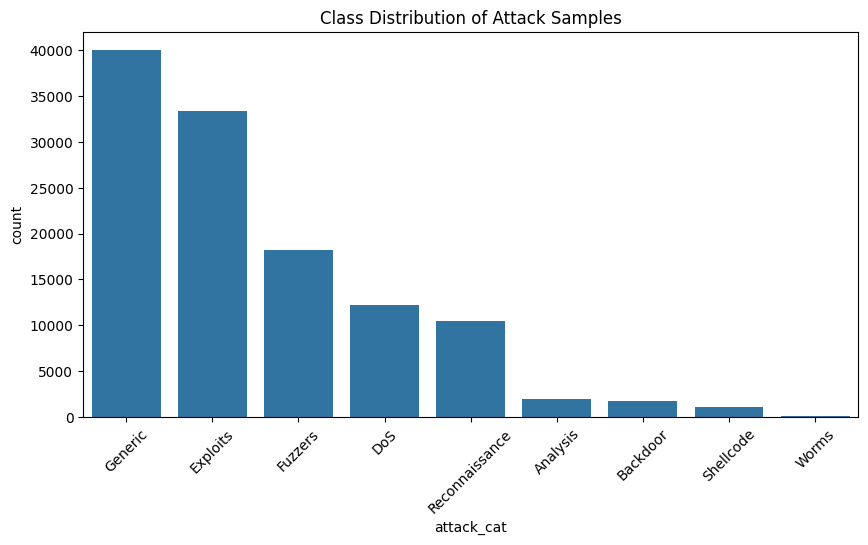

In [5]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df_train_attack['attack_cat'], order=df_train_attack['attack_cat'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Class Distribution of Attack Samples')
plt.show()

To measure how severe the imbalance is, I'm use imbalance ratio (IR) and other statistical metrics.
The imbalance ratio (IR) tells us how imbalanced the dataset is. It’s calculated as:

IR = Majority class count / Minority class count

- If IR > 1.5, the dataset is imbalanced.  
- If IR > 10, the imbalance is severe.  
- If any class has less than 5% of the dataset, which indicates a significant imbalance.

In [6]:
# Find the majority and minority class sizes
class_counts = df_train_attack['attack_cat'].value_counts()
majority_class = class_counts.max()
minority_class = class_counts.min()

# Compute imbalance ratio
imbalance_ratio = majority_class / minority_class
print(f"Imbalance Ratio (IR): {imbalance_ratio:.2f}\n")

# Compute percentage distribution
total_samples = len(df_train_attack)
percentages = (class_counts / total_samples) * 100
print(percentages)

Imbalance Ratio (IR): 307.69

attack_cat
Generic           33.517400
Exploits          27.981163
Fuzzers           15.237010
DoS               10.276435
Reconnaissance     8.790776
Analysis           1.675870
Backdoor           1.463034
Shellcode          0.949380
Worms              0.108932
Name: count, dtype: float64


The answer above question is:
- There is few minority attack classes **less then 5%** of the dataset here: Worms, Shellcode, Backdoor, and Analysis.
- The Imbalance Ratio is 307.69 which indicate the dataset is **highly imbalance!**.

Normalize Features  
GANs work best when features are scaled between **0 and 1**

In [ ]:
# Drop unnecessary columns first
df_train_attack.drop(columns=['id', 'label', 'service', 'state', 'proto'], inplace=True)

# Select only numerical features
numerical_cols = df_train_attack.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Apply MinMaxScalar to normalize the numerical features
scaler = MinMaxScaler()
df_train_attack[numerical_cols] = scaler.fit_transform(df_train_attack[numerical_cols])

# Display the first 5 rows
df_train_attack.head()

Selected numerical columns: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']


C:\Users\Rajasa\AppData\Local\Temp\ipykernel_17660\3056403719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_attack.drop(columns=['id', 'label', 'service', 'state', 'proto'], inplace=True)
C:\Users\Rajasa\AppData\Local\Temp\ipykernel_17660\3056403719.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_attack[numerical_cols] = scaler.fit_transform(df_train_attack[numerical_cols])


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
47911,1.500024e-07,0.000104,0.0,0.000011,0.0,0.111111,0.996078,0.0,0.014845,0.0,...,0.00,0.000000,0.046875,0.0,0.0,0.0,0.016949,0.058824,0.0,Backdoor
47912,1.500024e-07,0.000104,0.0,0.000011,0.0,0.111111,0.996078,0.0,0.014845,0.0,...,0.02,0.033333,0.093750,0.0,0.0,0.0,0.016949,0.117647,0.0,Backdoor
47913,1.500024e-07,0.000104,0.0,0.000011,0.0,0.111111,0.996078,0.0,0.014845,0.0,...,0.00,0.000000,0.078125,0.0,0.0,0.0,0.000000,0.098039,0.0,Backdoor
47914,5.000080e-08,0.000104,0.0,0.000011,0.0,0.333333,0.996078,0.0,0.044534,0.0,...,0.02,0.033333,0.093750,0.0,0.0,0.0,0.016949,0.098039,0.0,Backdoor
47915,1.333355e-07,0.000104,0.0,0.000011,0.0,0.125000,0.996078,0.0,0.016700,0.0,...,0.00,0.000000,0.046875,0.0,0.0,0.0,0.169492,0.058824,0.0,Backdoor


## Define the GAN Architecture

GAN Architecture Overview  
A GAN consist of two networks:
1. **Generator (G)** --> Takes random noise and generates fake attack samples.
2. **Discriminator (D)** --> Determine if a sample is real or fake.

Define the Generator  
The generator takes **random noise** as input and outputs a synthetic attack sample.

In [9]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), # Fully connected layer
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim), # Output the same number of features as the dataset
            nn.Tanh() # Output values between -1 and 1
        )
    
    def forward(self, z):
        return self.model(z)

**input_dim** --> Size of the random noise (e.g., 100).  
**output_dim** --> Number of features in your dataset.

Define the Discriminator  
The discriminator classifies data as **real (1)** or **fake (0)**.

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2), 
            nn.Linear(128, 1), 
            nn.Sigmoid() # Output probability of being real
        )
    
    def forward(self, x):
        return self.model(x)

Uses **LeakyReLU** to avoid dead neurons.  
Ends with **Sigmoid** to output probability.

Initialize Models & Optimizers

In [11]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define dimensions
input_dim = 100 # Random noise size
output_dim = len(numerical_cols) # Number of features in dataset

# Set device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize models
generator = Generator(input_dim, output_dim).to(device)
discriminator = Discriminator(output_dim).to(device)

# Optimizers & Loss Functions
lr = 0.0002 # Learning rate
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss() # Binary Cross-Entropy loss

Using device: cuda


**criterion** helps measure how well the discriminator differentiates real vs. fake.  
**Adam optimizer** helps in faster convergence.

## Training the GAN

GAN Training Process
- A separate GAN model was trained **for each minority attack category** except the majority class.
- Training was conducted for **1,000 epochs** with a **batch size of 64**.
- The generator and discriminator were optimized using the **Adam optimizer**.
- The training process was **efficiently executed on GPU**.

In [12]:
# Identify the majority class
majority_class = df_train_attack['attack_cat'].value_counts().idxmax()
classes_to_train = df_train_attack['attack_cat'].unique().tolist()
classes_to_train.remove(majority_class)  # Exclude the majority class from training

# Training parameters
num_epochs = 1000 # Set the number of epochs for training
batch_size = 64 # Set the batch size for each iteration

# Loop through each minority attack class and train a separate GAN for each
for attack_class in classes_to_train:
    print(f"Training GAN for {attack_class}...")

    # Extract only sampls of this attack class
    real_data_class = df_train_attack[df_train_attack['attack_cat'] == attack_class][numerical_cols].values
    real_data_class = torch.tensor(real_data_class, dtype=torch.float32).to(device)

    # Train the GAN for this specific attack class
    for epoch in range(num_epochs):
        # Shuffle data at the start of each epoch
        real_data_class = real_data_class[torch.randperm(real_data_class.size(0))]

        # Train the GAN in mini-batches (batch_size)
        for i in range(0, len(real_data_class), batch_size):
            # Define batch_data as a slice of real_data_class
            batch_data = real_data_class[i:i+batch_size].to(device)

            ### Step 1: Train Discriminator ###
            optimizer_D.zero_grad()

            # Real samples
            real_labels = torch.ones(batch_data.shape[0], 1).to(device) # Real data labels = 1
            real_output = discriminator(batch_data)
            loss_real = criterion(real_output, real_labels)

            # Fake samples
            noise = torch.randn(batch_data.shape[0], input_dim).to(device) # Generate random noise
            fake_data = generator(noise) # Generate fake attack samples
            fake_labels = torch.zeros(batch_data.shape[0], 1).to(device) # Fake data labels = 0
            fake_output = discriminator(fake_data.detach()) # Detach to avoid generator update
            loss_fake = criterion(fake_output, fake_labels)

            # Total Discriminator loss
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

            ### Step 2: Train Generator ###
            optimizer_G.zero_grad()

            # Want to fool the discriminator
            fake_output = discriminator(fake_data)
            loss_G = criterion(fake_output, torch.ones(batch_data.shape[0], 1).to(device)) # Fake labels = 1 (to fool D)

            loss_G.backward()
            optimizer_G.step()

        # print(f"Epoch [{epoch+1}/{num_epochs}] done for {attack_class}")
        # Print updates only every 100 epochs and at the beginning & end
        if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}] done for {attack_class}")

    print(f"{attack_class} GAN training Done!")

Training GAN for Backdoor...
Epoch [1/1000] done for Backdoor
Epoch [100/1000] done for Backdoor
Epoch [200/1000] done for Backdoor
Epoch [300/1000] done for Backdoor
Epoch [400/1000] done for Backdoor
Epoch [500/1000] done for Backdoor
Epoch [600/1000] done for Backdoor
Epoch [700/1000] done for Backdoor
Epoch [800/1000] done for Backdoor
Epoch [900/1000] done for Backdoor
Epoch [1000/1000] done for Backdoor
Backdoor GAN training Done!
Training GAN for Analysis...
Epoch [1/1000] done for Analysis
Epoch [100/1000] done for Analysis
Epoch [200/1000] done for Analysis
Epoch [300/1000] done for Analysis
Epoch [400/1000] done for Analysis
Epoch [500/1000] done for Analysis
Epoch [600/1000] done for Analysis
Epoch [700/1000] done for Analysis
Epoch [800/1000] done for Analysis
Epoch [900/1000] done for Analysis
Epoch [1000/1000] done for Analysis
Analysis GAN training Done!
Training GAN for Fuzzers...
Epoch [1/1000] done for Fuzzers
Epoch [100/1000] done for Fuzzers
Epoch [200/1000] done fo

## Generate Synthetic Attack Samples

Synthetic Sample Generation
- After training, **synthetic samples** were generated for each **attack class except majority class** until all classes were balanced.
- The generated data was **merged** with the original dataset while preserving the class labels.
- The synthetic samples save to **CSV file** to avoid training the GAN again in the future when close this notebook.

In [13]:
# Identify the size of the majority class
majority_class_size = df_train_attack['attack_cat'].value_counts().max()

# Loop through each minority attack class and generate synthetic samples
synthetic_dataframes = []

for attack_class in classes_to_train:
    print(f"Generating synthetic samples for {attack_class}...")

    # Extract only samples of this attack class
    real_data_class = df_train_attack[df_train_attack['attack_cat'] == attack_class][numerical_cols].values
    real_data_class = torch.tensor(real_data_class, dtype=torch.float32).to(device)

    # Generate synthetic samples after training the GAN
    num_samples_needed = majority_class_size - len(real_data_class) # Calculate number of synthetic samples needed
    noise = torch.randn(num_samples_needed, input_dim, device=device)
    synthetic_samples = generator(noise).detach().cpu().numpy()

    # Convert back to original scale
    synthetic_samples = scaler.inverse_transform(synthetic_samples)

    # Create DataFrame for the synthetic samples and label them with the same attack class
    synthetic_df = pd.DataFrame(synthetic_samples, columns=numerical_cols)
    synthetic_df['attack_cat'] = attack_class # Same name as the original attack class

    # Store for merging later
    synthetic_dataframes.append(synthetic_df)

# Combine all synthetic data into one DataFrame
final_synthetic_df = pd.concat(synthetic_dataframes, ignore_index=True)

# Save the synthetic data to a CSV file
final_synthetic_df.to_csv('synthetic_attack_data.csv', index=False)
print("Synthetic attack samples for all minority classes saved!")

Generating synthetic samples for Backdoor...
Generating synthetic samples for Analysis...
Generating synthetic samples for Fuzzers...
Generating synthetic samples for Shellcode...
Generating synthetic samples for Reconnaissance...
Generating synthetic samples for Exploits...
Generating synthetic samples for DoS...
Generating synthetic samples for Worms...
Synthetic attack samples for all minority classes saved!


In [14]:
# Merge synthetic samples with the original dataset
df_final = pd.concat([df_train_attack, final_synthetic_df], ignore_index=True)

# Save the merged dataset to a new CSV file
df_final.to_csv('balanced_attack_data.csv', index=False)
print("Merged dataset saved as 'balanced_attack_data.csv'!")

Merged dataset saved as 'balanced_attack_data.csv'!


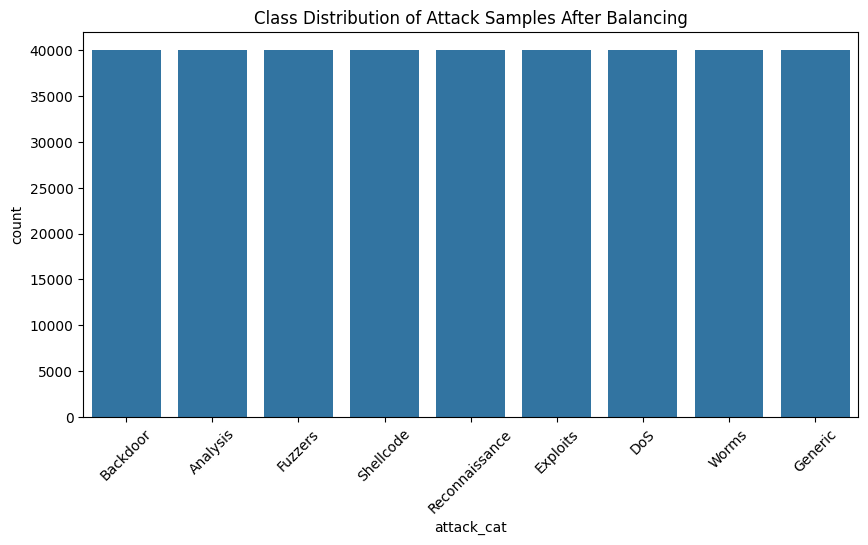

In [15]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df_final['attack_cat'], order=df_final['attack_cat'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Class Distribution of Attack Samples After Balancing')
plt.show()

In [16]:
# Find the majority and minority class sizes
class_counts = df_final['attack_cat'].value_counts()
majority_class = class_counts.max()
minority_class = class_counts.min()

# Compute imbalance ratio
imbalance_ratio = majority_class / minority_class
print(f"Imbalance Ratio (IR): {imbalance_ratio:.2f}\n")

# Compute percentage distribution
total_samples = len(df_final)
percentages = (class_counts / total_samples) * 100
print(percentages)

Imbalance Ratio (IR): 1.00

attack_cat
Backdoor          11.111111
Analysis          11.111111
Fuzzers           11.111111
Shellcode         11.111111
Reconnaissance    11.111111
Exploits          11.111111
DoS               11.111111
Worms             11.111111
Generic           11.111111
Name: count, dtype: float64


Final Balanced Dataset  
After generating and merging synthetic attack samples, the **new Imbalance Ratio (IR) is 1.00**, meaning all attack categories now have **equal representation**.